<a href="https://colab.research.google.com/github/raeubaen/RadioMonteCarlo/blob/main/XGBoost_RMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import xgboost as xgb
import time

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

from sklearn.model_selection import train_test_split


np.random.seed() # shuffle random seed generator


!nvidia-smi

Tue Jun 21 20:19:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
'''
!wget https://www.dropbox.com/s/qrv8y0l3wlcgx8f/bkg_etrn.npy?dl=1 -O bkg_etrn.npy
!wget https://www.dropbox.com/s/va1mo6um1al1l5r/signal_etrn.npy?dl=1 -O signal_etrn.npy
'''

!wget https://www.dropbox.com/s/fqxxodsx3xpe9ge/mnbs_etrn.npy?dl=1 -O bkg_etrn.npy

!wget https://www.dropbox.com/s/bto89w1z2knnak7/signal_etrn.npy?dl=1 -O signal_etrn.npy

--2022-06-21 20:19:49--  https://www.dropbox.com/s/fqxxodsx3xpe9ge/mnbs_etrn.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/fqxxodsx3xpe9ge/mnbs_etrn.npy [following]
--2022-06-21 20:19:50--  https://www.dropbox.com/s/dl/fqxxodsx3xpe9ge/mnbs_etrn.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8a831603f94f81578544a6c110.dl.dropboxusercontent.com/cd/0/get/BnoGQvv940GNYzJiMSuWanXnVLkSiAh1UpKBu-62EpzPEI1ivbgKkPnGiaT_ByJEg5aRniVsSeJfxPtjWikTiSZTr-l0_hVVscrQbswSdsihr2sYOjNVYEaORL9M_U9kGxh7yfa6pBoU_-IKq7I_5-F-ZVtZaXZVfzerwv3agDb-WZkHC_vBr5ow2_mjaAWW5u0/file?dl=1# [following]
--2022-06-21 20:19:50--  https://uc8a831603f94f81578544a6c110.dl.dropboxusercontent.com/cd/0/get/BnoGQvv940GNYzJiMSuWanXnVLkSiAh1UpKBu-62Ep

In [3]:
def spectrum(x):
  kmax = 90.4
  x[x>kmax] = 0
  return (1-2*x/kmax+2*x/kmax*x/kmax)*x/kmax*(1-x/kmax)**2

def import_data(signal_file, bkg_file, emin, nlim, read_from_txt, cols_cut):
  #nlim 150000 emin 40 cols_cut -1 senza etrn

  np.random.seed() # shuffle random seed generator

  if read_from_txt:
    signal_numpy_data = np.loadtxt(signal_file)[:nlim, :cols_cut]

    signal_numpy_data = signal_numpy_data[signal_numpy_data[:, 0]>emin]

    print(signal_numpy_data[:, 0].shape)

    signal_numpy_data = signal_numpy_data[np.random.choice(
      len(signal_numpy_data), size=len(signal_numpy_data),
      p=spectrum(signal_numpy_data[:, 0])/np.sum(spectrum(signal_numpy_data[:, 0]))
    )]

    np.save(signal_file, signal_numpy_data)

  else:
      signal_numpy_data = np.load(signal_file)[:nlim, :cols_cut]

  signal_numpy_data = signal_numpy_data[signal_numpy_data[:, 0]>emin]

  print(f"Signal Data shape: {signal_numpy_data.shape}")


  if read_from_txt: 
      bkg_numpy_data = np.loadtxt(bkg_file)[:nlim, :cols_cut]
      bkg_numpy_data = bkg_numpy_data[bkg_numpy_data[:, 0]>emin]
      np.save(bkg_file, bkg_numpy_data)
  else:
      bkg_numpy_data = np.load(bkg_file)[:nlim, :cols_cut]

  bkg_numpy_data = bkg_numpy_data[bkg_numpy_data[:, 0]>emin]

  print(f"bkg Data shape: {bkg_numpy_data.shape}")

  return (signal_numpy_data, bkg_numpy_data)

In [4]:
'''
signal_numpy_data, bkg_numpy_data = import_data(
    "signal.npy", "bkg.npy", 40, 150000, 0, -1
)
'''

signal_numpy_data, bkg_numpy_data = import_data(
    "signal_etrn.npy", "bkg_etrn.npy", 50, 1000000, 0, 4
)

train_to_test_ratio = 0.1

X = np.concatenate((signal_numpy_data, bkg_numpy_data))
Y = np.concatenate((np.ones(len(signal_numpy_data)), np.zeros(len(bkg_numpy_data))))


signal_weight = 330/150e3 * 100
mnbs_weight = 1.3/5.25 * 100

W = np.concatenate(
    [ np.ones((len(signal_numpy_data)))*signal_weight, np.ones((len(bkg_numpy_data)))*mnbs_weight ]
)

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(
    X, Y, W,
    train_size=train_to_test_ratio,
    test_size=1.0 - train_to_test_ratio
)

X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(
    X, Y, W,
    train_size=train_to_test_ratio,
    test_size=1.0 - train_to_test_ratio
)


Signal Data shape: (41372, 4)
bkg Data shape: (1132, 4)
X shape: (42504, 4)
Y shape: (42504,)


In [14]:
time_start = time.time()
xg_train = xgb.DMatrix(X_train, label=Y_train, weight=W_train)
xg_test = xgb.DMatrix(X_test, label=Y_test, weight=W_test)
xg_val = xgb.DMatrix(X_val, label=Y_val, weight=W_val)

param = {
    # use softmax multi-class classification
    # scale weight of positive examples
    'objective': 'binary:logistic',
    'n_estimators': 20,
    'max_depth': 5,
    'silent': 0,
    'gpu_id': 0,
    #'max_bin': 6,
    'tree_method': 'gpu_hist',
    "eval_metric": [
      "aucpr",
    ]
}



# watchlist allows us to monitor the evaluation result on all data in the list 
watchlist = [(xg_train, 'train'), (xg_val, 'val')]
num_round = 50

bst = xgb.train(param, xg_train, num_round, watchlist)

print(time.time() - time_start)


[0]	train-aucpr:0.958569	val-aucpr:0.854916
[1]	train-aucpr:0.972456	val-aucpr:0.870484
[2]	train-aucpr:0.986562	val-aucpr:0.892551
[3]	train-aucpr:0.98664	val-aucpr:0.891303
[4]	train-aucpr:0.988355	val-aucpr:0.89333
[5]	train-aucpr:0.992631	val-aucpr:0.918409
[6]	train-aucpr:0.993855	val-aucpr:0.89998
[7]	train-aucpr:0.994924	val-aucpr:0.905788
[8]	train-aucpr:0.996057	val-aucpr:0.906556
[9]	train-aucpr:0.997098	val-aucpr:0.907441
[10]	train-aucpr:0.997311	val-aucpr:0.911835
[11]	train-aucpr:0.99752	val-aucpr:0.906226
[12]	train-aucpr:0.997879	val-aucpr:0.912767
[13]	train-aucpr:0.998079	val-aucpr:0.91255
[14]	train-aucpr:0.998503	val-aucpr:0.904083
[15]	train-aucpr:0.998633	val-aucpr:0.904384
[16]	train-aucpr:0.998832	val-aucpr:0.903838
[17]	train-aucpr:0.999058	val-aucpr:0.905492
[18]	train-aucpr:0.999159	val-aucpr:0.900833
[19]	train-aucpr:0.999219	val-aucpr:0.904997
[20]	train-aucpr:0.999271	val-aucpr:0.902589
[21]	train-aucpr:0.999533	val-aucpr:0.909671
[22]	train-aucpr:0.999665

AUprC: 0.9168530407539821


Text(0, 0.5, 'Efficiency')

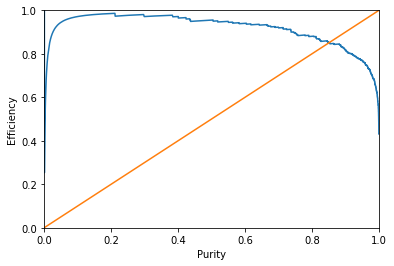

In [15]:
probs = bst.predict(xg_test)

prec, recall, thres = precision_recall_curve(Y_test, probs, sample_weight=W_test)

print(f"AUprC: {auc(recall, prec)}")

plt.plot(recall, prec)
plt.plot([0, 1], [0, 1])

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Purity")
plt.ylabel("Efficiency")